## Radius measurement at different z-sections

Until now, the colony images were taken through ~4mm agar. The GFP signal got distorted, and very noisy images were formed. The formed noise made it very hard to automate height measurements. Even with a naked eye, it was close to impossible to find the top of the colony. In this example, Glu 04/17/2021 and Gly 04/17/2021, there is nothing in between the lens and the colony, so the GFP signal is very clear. This opens up the possibility of automated radius and height measurements!

In [4]:
%matplotlib inline

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr
import pandas as pd
import datetime
import json

from matplotlib import pyplot as plt

from bs4 import BeautifulSoup

from find_circle import make_circle

In [5]:
# Go through each merged file and collect the resized image in a numpy array
def get_image_sequence(video_folder, exp_name, acq_name, t_str, zstr_ar, img_dims):
    # Initialize the img numpy array
    img_seq = np.zeros((img_dims[0], img_dims[1], len(zstr_ar)), np.uint8)
    # Go over each z-stack image
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}", f"{exp_name}_{acq_name}.avi")

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)
    for zix in range(len(zstr_ar)):
        z_str = zstr_ar[zix]
        # Collect the path of the merged files
        try:
            success, frame = vidcap.read()
            
            # Convert to grayscale
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add to image sequence array
            img_seq[:,:,zix] = frame_gray

        except Exception as e:
            print(success)
            print(f"Error! Cannot read video from path {video_path}")
        
    return img_seq

In [6]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        elif isinstance(obj, datetime.datetime):
            return str(obj)

        return json.JSONEncoder.default(self, obj)

In [38]:
exp_name = "EQ59_Glu_20mM_PBS_30mM"
base_folder = os.path.join("D:\\", "Tolga")

exp_folder = os.path.join(base_folder, f"{exp_name}")
inner = True
tstr = "t0"
dim = (512,512)
ksz_um = 10 # Kernel size for filters in um

plate_csv_path = os.path.join(exp_folder, f"{exp_name}_Plates.csv")
timepoint_csv_path = os.path.join(exp_folder, f"{exp_name}_TimePoints.csv")

plate_df = pd.read_csv(plate_csv_path)
timepoint_df = pd.read_csv(timepoint_csv_path)
df = plate_df.merge(timepoint_df, on="plate_id", how="inner")

tar = [] # Timepoint in hours
tpid_rh_lst = []
height = [] # Max height: surface to top at the center
radius = [] # Max radius: center to edge at the surface

rarz = [] # for each acquisition, collect radius at each z-section
zarz = [] # each acquisition has its own z-sections. save all z values

cross_section_df = pd.DataFrame()
# Run through each acquisition
for (index,row) in df.iterrows():
#     if index == 1:
#         break
    # something is wrong with tp_id = 6 for  Glucose
    plt_id = row["plate_id"]
    tp_id = row["timepoint_id"]
    
    print(f"plate_id: {plt_id} - tp_id: {tp_id}")

#     if tp_id == 6:
#         continue
    
    acq_name = f"TileScan_Plt{plt_id}_Tp{tp_id}"
    metadata = mf.collect_metadata(exp_folder, exp_name, acq_name, inner=inner)

    hours = (metadata["start_time"]- pd.Timestamp(row["time_prepared"])).total_seconds()/3600
    tar.append(hours)
    
    # Calculate kernel size in pixels for fixed length
    xvoxel = metadata["dimensions"]["X"]["Voxel"]
    yvoxel = metadata["dimensions"]["Y"]["Voxel"]
    xnum = metadata["dimensions"]["X"]["NumberOfElements"]
    ynum = metadata["dimensions"]["Y"]["NumberOfElements"]
    w = metadata["tiles"]["xix_unique_ar"].size*xnum
    h = metadata["tiles"]["yix_unique_ar"].size*ynum

    ksz_um = 10 # Kernel size for filters in um

    ksz_px = ksz_um/xvoxel
    # Make kernel size an odd integer
    ksz_px = int(ksz_px/2)*2 + 1
    print(f"width: {w} - height: {h}")
    print(f"kernel um: {ksz_um} - kernel px: {ksz_px}")
    
    # Go through each z and collect radius 
    zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
    zvoxel = -metadata["dimensions"]["Z"]["Voxel"]
    zar_um = []
    rar_um = []
    tp_id_lst = []
    
    # First, collect image sequence
    # Find the number of digits
    znum_digit = len(str(zsz-1))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"

    # calculate z_strar for each z_str value
    z_strar = np.zeros(zsz, dtype="<U6")
    for zix in range(zsz):
        z_strar[zix] = zstr_holder % zix


    # Read an image
    video_folder = os.path.join(exp_folder, "Videos_Full_Unmarked")

    print("\nCollecting image sequence")
    img_seq = get_image_sequence(video_folder, exp_name, acq_name, tstr, z_strar, dim)
    
    print("Calculating radius for each z-section: ")
    for zix in range(zsz):
#         print(f"{zix}/{zsz}", end="\r", flush=True)
        roi_image = img_seq[:, :, zix]
        blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    #     blurred_image = roi_image
        _, thresh_image = cv2.threshold(blurred_image, 80, 255, cv2.THRESH_BINARY)

        zar_um.append(zix*zvoxel)
        tp_id_lst.append(tp_id)
        
#         # Parse the positive points into 
#         (yix,xix) = np.where(thresh_image>0)
        contours, hierarchy = cv2.findContours(np.uint8(thresh_image>0), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            points = np.vstack(contours).squeeze()
            if points.size > 2:
    #             points = []
    #             for ix in range(len(xix)):
    #                 points.append((xix[ix], yix[ix]))
                (x,y,rad) = make_circle(points)
                rar_um.append(rad*xvoxel*w/dim[0])
            else:
                rar_um.append(0)

        else:
            rar_um.append(0)
            
    # Calculate height
    r = np.array(rar_um)
    z = np.array(zar_um)
    idx, = np.where(r > 0)
    surf = z[np.argmax(r)]
    top = z[idx[-1]]
    h = top-surf
    
    # Calculate max radius
    
    tpid_rh_lst.append(tp_id)
    radius.append(max(r))
    height.append(h)
    rarz.append(rar_um)
    zarz.append(zar_um)
    
    data = {"timepoint_id": tp_id_lst, "z(um)": z, "z-surf(um)": z-surf, "r(um)": r}
    cross_section_df = cross_section_df.append(pd.DataFrame(data), ignore_index=True)

plate_id: 1 - tp_id: 5
width: 3072 - height: 3072
kernel um: 10 - kernel px: 23

Calculating radius for each z-section: 
plate_id: 1 - tp_id: 10
width: 4096 - height: 4096
kernel um: 10 - kernel px: 11

Calculating radius for each z-section: 
plate_id: 2 - tp_id: 4
width: 3072 - height: 3072
kernel um: 10 - kernel px: 27

Calculating radius for each z-section: 
plate_id: 2 - tp_id: 9
width: 4096 - height: 4096
kernel um: 10 - kernel px: 11

Calculating radius for each z-section: 
plate_id: 3 - tp_id: 3
width: 3072 - height: 3072
kernel um: 10 - kernel px: 51

Calculating radius for each z-section: 
plate_id: 3 - tp_id: 8
width: 3072 - height: 3072
kernel um: 10 - kernel px: 11

Calculating radius for each z-section: 
plate_id: 4 - tp_id: 2
width: 3072 - height: 3072
kernel um: 10 - kernel px: 43

Calculating radius for each z-section: 
plate_id: 4 - tp_id: 7
width: 3072 - height: 3072
kernel um: 10 - kernel px: 11

Calculating radius for each z-section: 
plate_id: 5 - tp_id: 6
width: 3

Text(0.5, 1.0, 'EQ59_Glu_20mM_PBS_30mM')

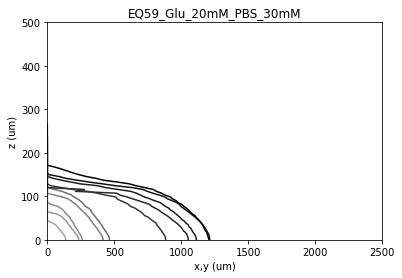

In [39]:
# Cross-sections
fig,ax = plt.subplots()
for rix in range(len(rarz)):
    # Rearrange the z values
    r = np.array(rarz[rix])
    z = np.array(zarz[rix])
    idx, = np.where(r > 0)
    surf = z[np.argmax(r)]
    top = z[idx[-1]]
    h = top-surf
    c = 1-tar[rix]/max(tar)
    ax.plot(r, z-surf, color=(c,c,c), label="%.2f h, %d um" % (tar[rix], h))
    
# ax.legend()
ax.set_xlim(0, 2500)
ax.set_ylim(0,500)
ax.set_xlabel("x,y (um)")
ax.set_ylabel("z (um)")
ax.set_title(exp_name)

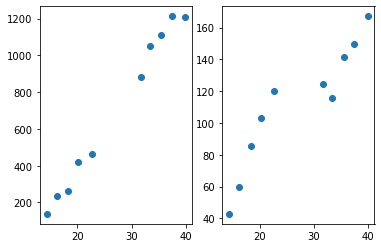

In [40]:
# height and radius
fig, axs = plt.subplots(1,2)
axs[0].plot(tar, radius, 'o')
axs[1].plot(tar, height, 'o')


In [41]:
cross_section_df.to_csv(os.path.join(exp_folder, f"{exp_name}_CrossSection.csv"), index=False)

In [42]:
cross_section_df

,timepoint_id,z(um),z-surf(um),r(um)
0,5,0.000,-64.290,0.0
1,5,4.286,-60.004,0.0
2,5,8.572,-55.718,0.0
3,5,12.858,-51.432,0.0
4,5,17.144,-47.146,0.0
...,...,...,...,...
630,1,150.010,98.578,0.0
631,1,154.296,102.864,0.0
632,1,158.582,107.150,0.0
633,1,162.868,111.436,0.0


In [43]:
radius_height_data = {"timepoint_df": tpid_rh_lst, "radius(um)": radius, "height(um)": height, "Time(hr)": tar}
radius_height_df = pd.DataFrame(radius_height_data)
radius_height_df.to_csv(os.path.join(exp_folder, f"{exp_name}_RadiusHeight.csv"), index=False)

In [44]:
radius_height_df

,timepoint_df,radius(um),height(um),Time(hr)
0,5,464.249997,120.008,22.623655
1,10,1207.083491,167.154,39.864044
2,4,417.269667,102.864,20.197520
3,9,1212.836823,150.010,37.401688
4,3,260.951185,85.720,18.269085
5,8,1112.782499,141.438,35.471886
6,2,235.193827,60.004,16.197480
7,7,1052.998957,115.722,33.387063
8,6,883.805645,124.294,31.691950
9,1,137.482650,42.860,14.337301


In [45]:
json_fname = os.path.join(exp_folder, f"{exp_name}_Metadata.json")
with open(json_fname, 'w') as fp:
    json.dump(metadata, fp, cls=NumpyEncoder)

In [46]:
metadata

{'dimensions': {'X': {'Length': 107.7,
   'NumberOfElements': 1024,
   'Unit': 'um',
   'Voxel': 0.105},
  'Y': {'Length': 107.7,
   'NumberOfElements': 1024,
   'Unit': 'um',
   'Voxel': 0.105},
  'Z': {'Length': -167.17,
   'NumberOfElements': 40,
   'Unit': 'um',
   'Voxel': -4.286},
  'Stage': {'Length': '0.00',
   'NumberOfElements': 16,
   'Unit': '',
   'Voxel': None}},
 'tiles': {'xix_lst': array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]),
  'yix_lst': array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]),
  'xix_unique_ar': array([0, 1, 2, 3]),
  'yix_unique_ar': array([0, 1, 2, 3]),
  'xpos_lst': array([89913.5812152, 89913.5812152, 89913.5812152, 89913.5812152,
         90010.4479188, 90010.4479188, 90010.4479188, 90010.4479188,
         90107.3146224, 90107.3146224, 90107.3146224, 90107.3146224,
         90204.181326 , 90204.181326 , 90204.181326 , 90204.181326 ]),
  'ypos_lst': array([44129.4853944, 44226.352098 , 44323.2188016, 44420.0855052,
         44129.48539

10mM PBS gr = 0.7006938662078075/h
30mM PBS gr = 0.7970523786744316/h
100mM PBS gr = 0.9324845417735139/h


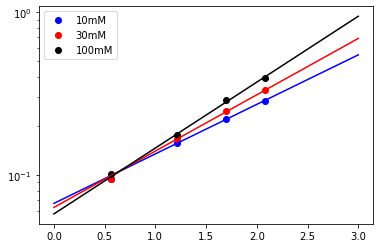

In [25]:
hour = np.array([0,1,1,2])
mins = np.array([34,13,42,5])

time = hour + mins/60

od10 = np.array([0.095, 0.156, 0.222, 0.286])
od30 = np.array([0.095, 0.166, 0.246, 0.331])
od100 = np.array([0.101, 0.177, 0.288, 0.396])

fig,ax = plt.subplots()
ax.semilogy(time, od10, 'bo', time, od30, 'ro', time, od100, 'ko')
ax.legend(['10mM', '30mM', '100mM'])

p10 = np.polyfit(time[1:], np.log(od10[1:]),1)
p30 = np.polyfit(time[1:], np.log(od30[1:]),1)
p100 = np.polyfit(time[1:], np.log(od100[1:]),1)

print(f'10mM PBS gr = {p10[0]}/h')
print(f'30mM PBS gr = {p30[0]}/h')
print(f'100mM PBS gr = {p100[0]}/h')

x = np.linspace(0,3)
y10 = np.exp(p10[1] + x*p10[0])
ax.plot(x,y10,'b-')
y30 = np.exp(p30[1] + x*p30[0])
ax.plot(x,y30,'r-')
y100 = np.exp(p100[1] + x*p100[0])
ax.plot(x,y100,'k-')